In [262]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from scipy.stats import lognorm
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



forest = pd.read_csv('./csv/forest.csv', sep = ',')
forest_area = pd.read_csv('./csv/forest_area.csv', sep = ',')
brazil_loss = pd.read_csv('./csv/brazil_loss.csv', sep = ',')
soybean_use = pd.read_csv('./csv/soybean_use.csv', sep = ',')
vegetable_oil = pd.read_csv('./csv/vegetable_oil.csv', sep = ',')
population = pd.read_csv('./csv/population.csv', index_col=[0], sep = ',')
pd.set_option("max_rows", 200)
sns.set_style('darkgrid')
def tamanhoPlot(x, y):
    fig_dims = (x, y)
    fig, ax = plt.subplots(figsize=fig_dims)
    return ax

In [263]:
def filtro(df):
    df1 = df[(df.Código.notna()) & (df['Entidade'] != 'World')]
    df1.dropna(inplace=True)
    return df1

# Criando o dataframe do desmatamento

In [264]:
data = filtro(forest)
data.sort_values(['Conversão_líquida_de_floresta'], inplace=True)
data

,Entidade,Código,Ano,Conversão_líquida_de_floresta
47,Brazil,BRA,2000,-3950790.0
46,Brazil,BRA,1990,-3780940.0
195,Indonesia,IDN,1990,-1726500.0
48,Brazil,BRA,2010,-1539180.0
49,Brazil,BRA,2015,-1453040.0
...,...,...,...,...
14,Australia,AUS,2010,709680.0
83,China,CHN,2010,1936770.0
84,China,CHN,2015,1936790.0
81,China,CHN,1990,1986000.0


In [265]:
data_area = forest_area[(forest_area.Código.notna()) &(forest_area['Entidade'] != 'World')]
data_f = filtro(forest)
data_area.sort_values('Área_de_Floresta', ascending=False, inplace=True)

data = pd.merge(data_f, data_area)
data.sort_values(['Área_de_Floresta'], ascending=False, inplace=True)
data_vo = filtro(vegetable_oil)
data_test = data_vo.groupby(['Entidade','Código','Ano']).Produção_Óleo.sum().reset_index()
data = pd.merge(data, data_test)


In [266]:
data = pd.merge(data, population)
data['Perde'] = np.select((data.Conversão_líquida_de_floresta<0, data.Conversão_líquida_de_floresta>0), (1,0), 1)
def normalizaPelaPop(data):
    data.Área_de_Floresta = data.Área_de_Floresta / data.População
    data.Conversão_líquida_de_floresta = data.Conversão_líquida_de_floresta / data.População
    data.Produção_Óleo = data.Produção_Óleo / data.População
    return data

def separaData(data):
    return data.iloc[:,:3], data.iloc[:,4:7], data.iloc[:,3:4], data.iloc[:,7:8]
data_string, data_value,  y, target = separaData(data)


# Exploratore Analysis

## Boxplots

<AxesSubplot:title={'center':'Área_de_Floresta'}, xlabel='[Ano]'>

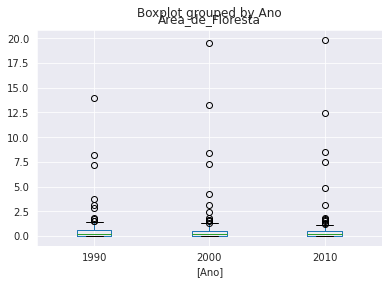

In [267]:
data.boxplot(['Área_de_Floresta'],by = ['Ano'])

<AxesSubplot:title={'center':'Conversão_líquida_de_floresta'}, xlabel='[Ano]'>

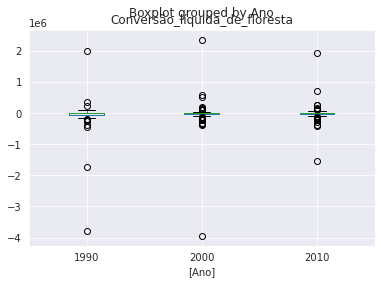

In [268]:
data.boxplot(['Conversão_líquida_de_floresta'],by = ['Ano'])

<AxesSubplot:title={'center':'Produção_Óleo'}, xlabel='[Ano]'>

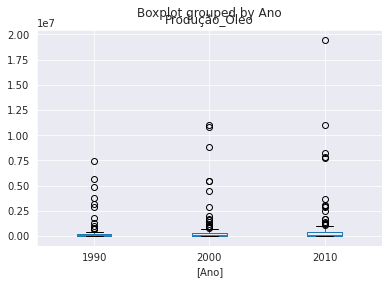

In [269]:
data.boxplot(['Produção_Óleo'],by = ['Ano'])

In [270]:
mono = pd.DataFrame({'Estatísticas' : ['Contagem', 'Média', 'Desvio Padrão', 'Mínimo', '1º Quartil', 'Mediana', '3º Quartil', 'Máximo', 'Distorção'],
                     'Área de Floresta %': [data.Área_de_Floresta.count(), data.Área_de_Floresta.mean(), data.Área_de_Floresta.std(),
                                          data.Área_de_Floresta.min(), data.Área_de_Floresta.quantile(.25), data.Área_de_Floresta.quantile(.50),
                                          data.Área_de_Floresta.quantile(.75), data.Área_de_Floresta.max(), data.Área_de_Floresta.skew()],
                     'Produção de Óleo': [data.Produção_Óleo.count(), data.Produção_Óleo.mean(), data.Produção_Óleo.std(),
                                          data.Produção_Óleo.min(), data.Produção_Óleo.quantile(.25), data.Produção_Óleo.quantile(.50),
                                          data.Produção_Óleo.quantile(.75), data.Produção_Óleo.max(), data.Produção_Óleo.skew()],
                     'População': [data.População.count(), data.População.mean(), data.População.std(),
                                          data.População.min(), data.População.quantile(.25), data.População.quantile(.50),
                                          data.População.quantile(.75), data.População.max(), data.População.skew()]})
mono

,Estatísticas,Área de Floresta %,Produção de Óleo,População
0,Contagem,260.000000,2.600000e+02,2.600000e+02
1,Média,0.891752,7.650162e+05,5.352181e+07
2,Desvio Padrão,2.507602,2.134971e+06,1.763970e+08
3,Mínimo,0.000019,1.800000e+01,1.192110e+05
4,1º Quartil,0.045767,1.531350e+04,4.336882e+06
5,Mediana,0.176241,7.677350e+04,1.022095e+07
6,3º Quartil,0.543165,3.640425e+05,3.247578e+07
7,Máximo,19.850775,1.948291e+07,1.337705e+09
8,Distorção,5.178593,4.877443e+00,5.948668e+00


# A distorção dos dados é bem alta, então uma transformação de dados se torna necessária

## Transformação logarítmica 

In [271]:
def tiraDistorcao(df):
    return np.log(df)

data_value = tiraDistorcao(data_value)


## Transformação Yeo-Johnson

In [272]:
def yeo_johnson(y):
    power = PowerTransformer()
    aux1 = pd.DataFrame(y)
    y = power.fit_transform(y)
    data_y = pd.DataFrame(y, index=aux1.index, columns=aux1.columns)
    return y, data_y

y, data_y = yeo_johnson(y)

<AxesSubplot:xlabel='Conversão_líquida_de_floresta', ylabel='Count'>

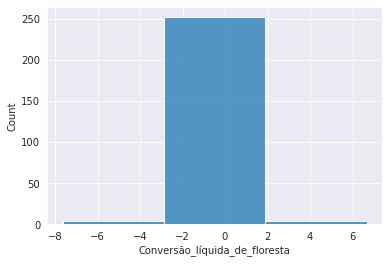

In [273]:
sns.histplot(data_y.Conversão_líquida_de_floresta,bins=3)

# Comparação dos dados antes e depois da transformação

<AxesSubplot:xlabel='Área_de_Floresta', ylabel='Count'>

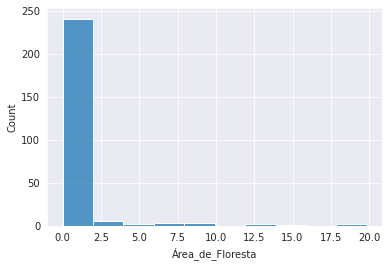

In [274]:
sns.histplot(data.Área_de_Floresta, bins=10)

<AxesSubplot:xlabel='Área_de_Floresta', ylabel='Count'>

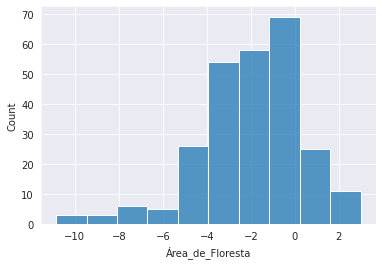

In [275]:
sns.histplot(data_value.Área_de_Floresta, bins=10)

<AxesSubplot:xlabel='Produção_Óleo', ylabel='Count'>

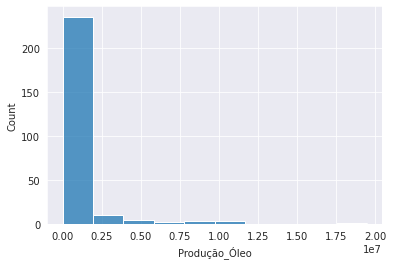

In [276]:
sns.histplot(data.Produção_Óleo, bins=10)

<AxesSubplot:xlabel='Produção_Óleo', ylabel='Count'>

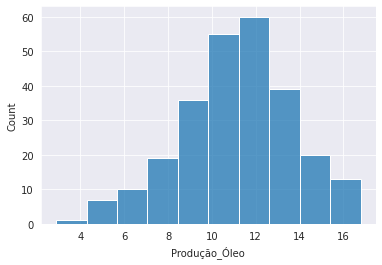

In [277]:
sns.histplot(data_value.Produção_Óleo, bins=10)

<AxesSubplot:xlabel='População', ylabel='Count'>

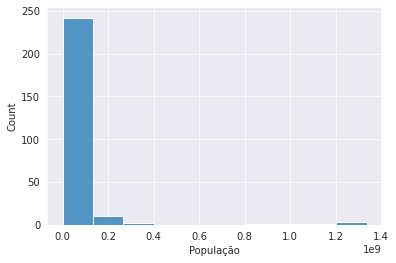

In [278]:
sns.histplot(data.População, bins=10)

<AxesSubplot:xlabel='População', ylabel='Count'>

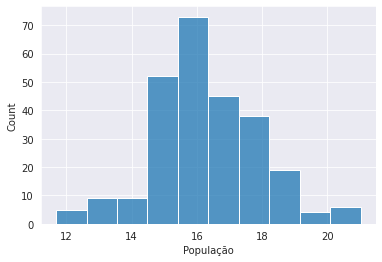

In [279]:
sns.histplot(data_value.População, bins=10)

# Análise bivariada

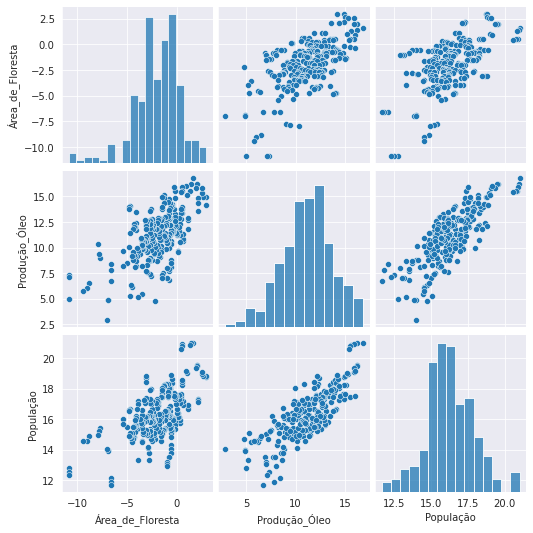

In [280]:
sns.pairplot(data=data_value)

# Matriz de correlação e mapa de calor

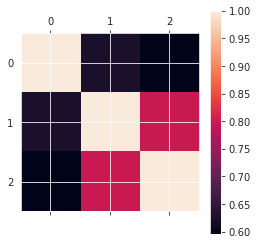

,Área_de_Floresta,Produção_Óleo,População
Área_de_Floresta,1.000000,0.626026,0.596391
Produção_Óleo,0.626026,1.000000,0.796013
População,0.596391,0.796013,1.000000


In [281]:
data.sort_values(['Conversão_líquida_de_floresta'], inplace=True)

plt.matshow(data_value.corr())
cb = plt.colorbar()

plt.show()
data_value.corr()

# Boxplot de como ficou os dados após as transformações

<AxesSubplot:>

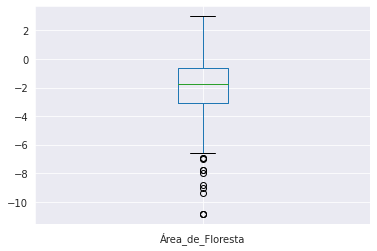

In [282]:
data_value.boxplot(column=['Área_de_Floresta'])

<AxesSubplot:>

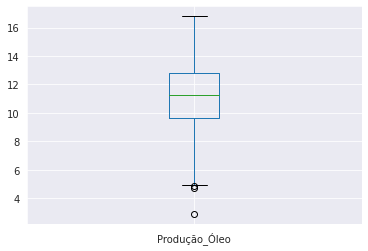

In [283]:
data_value.boxplot(column=['Produção_Óleo'])


<AxesSubplot:>

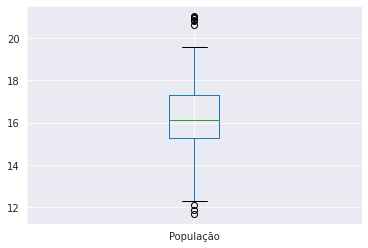

In [284]:
data_value.boxplot(column=['População'])

<AxesSubplot:>

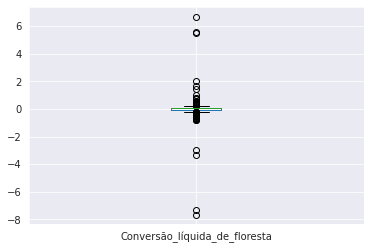

In [285]:
data_y.boxplot()

## Os dados acima não podem ser removidos, porque sem eles não ocorreria desmatamento no mundo. Basicamente, caso essas informações fossem retiradas, o mundo ganharia mais floresta do que está perdendo

# Esses outliers vão precisar de um Spatial sign transform

In [286]:
def spatialSign(df, s, s_aux):
    data_aux = df
    df = preprocessing.normalize(df, norm='l2')
    df = pd.DataFrame(df, index=data_aux.index, columns=data_aux.columns)
    s = preprocessing.normalize(s, norm='l2')
    s = pd.DataFrame(s, index=s_aux.index, columns=s_aux.columns)
    return df, s


# PCA


In [287]:
x = data_value.values
x = StandardScaler().fit_transform(x)

In [288]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, target], axis = 1)


In [289]:

fig = px.scatter(principalComponents, x=0, y=1, color=finalDf['Perde'], color_continuous_scale=["green", "red"])
fig.update_xaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='Black')


fig.show()

# Variância explicada

In [290]:
pca.fit(finalDf)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Componentes", "y": "Variância"}
)

# Biplot da PCA

In [291]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
features  = ['Área de Floresta', 'Produção de Óleo', 'População']
fig = px.scatter(principalComponents, x=0, y=1, color=finalDf['Perde'], color_continuous_scale=["green", "red"])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

# Regressão Linear

In [292]:
from sklearn.linear_model import LinearRegression, ridge_regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


## Agora é necessário separa os dados de teste e de treino

In [293]:
data_train = data[(data['Ano'] == 1990) | (data['Ano'] == 2000)]
data_test = data[(data['Ano']== 2010)]


### Treino

In [294]:
data_string_train, data_value_train,  y_train, target_train = separaData(data_train)
def trataDados(data_value, y):
    data_value = tiraDistorcao(data_value)
    y, data_y = yeo_johnson(y)
    data_value, y = spatialSign(data_value, y, data_y)
    return data_value, y
data_value_train.drop(columns=['População'], inplace=True)

In [295]:
X_train, y_train = trataDados(data_value_train, y_train)


In [296]:
data_string_test, data_value_test,  y_test, target_test = separaData(data_test)
data_value_test.drop(columns=['População'], inplace=True)
X_test, y_test = trataDados(data_value_test, y_test)

# Regressão simples

In [297]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

# Gráficos de cross-validation do modelo

# 5 splits

R² = 0.257
-1.106441620474968 

-0.010717322387989014


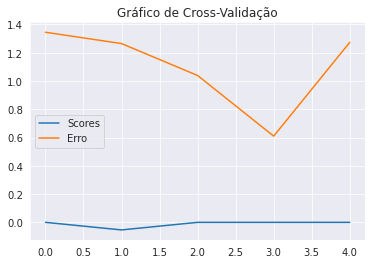

In [298]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(3)))
folds = KFold(n_splits = 5)
scores = cross_val_score(modelo, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(erro.mean(),"\n")
print(scores.mean())
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

# 10 splits

R² = 0.257


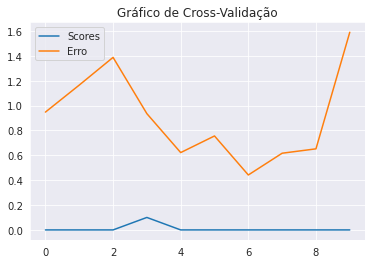

In [299]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(3)))
folds = KFold(n_splits = 10)
scores = cross_val_score(modelo, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)

(np.mean(abs(erro)))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

# R² scores 

In [300]:
y_previsto = modelo.predict(X_test)
metrics.r2_score(y_test, y_previsto).round(3)


0.258

# Erro

In [301]:
error = metrics.mean_squared_error(y_test, y_previsto)
error

0.637659371685875

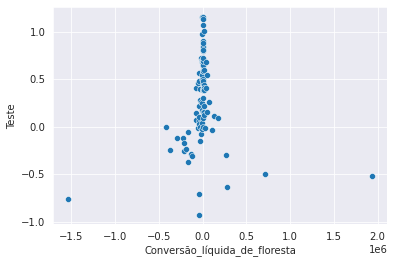

In [302]:
y_previsto = pd.DataFrame(y_previsto, index=y_test.index, columns=['Teste'])
df = pd.concat([data_test, y_previsto], axis=1)
#df.sort_values(['Área_de_Floresta'], ascending=False, inplace=True)
g = sns.scatterplot(x='Conversão_líquida_de_floresta', y='Teste', data=df, legend=False)

# Plot da regressão linear

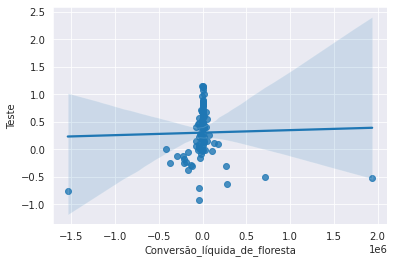

In [303]:
g = sns.regplot(x='Conversão_líquida_de_floresta', y='Teste', data=df)

In [304]:
from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_mean_squared_error',
                         cv=10, n_jobs=-1)
                        
print(np.sqrt(np.mean(abs(scores))))


0.10015051111888441


# Regressão de Ridge

In [305]:
from sklearn.linear_model import Ridge

# R² scores 

In [306]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

scores = clf.score(X_test, y_test)
scores


0.21524279102717947

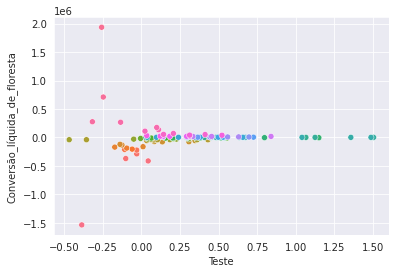

In [307]:
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=['Teste'])
dr = pd.concat([data_test, y_pred], axis=1)
g = sns.scatterplot(x='Teste', y='Conversão_líquida_de_floresta', data=dr, hue=dr.Entidade, legend=False)

# Plot da regressão de ridge

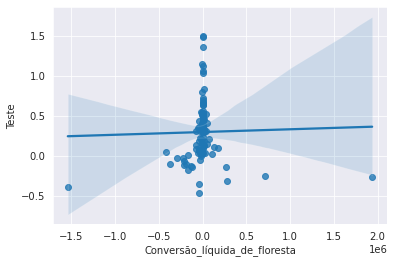

In [308]:
g = sns.regplot(x='Conversão_líquida_de_floresta', y='Teste', data=dr)

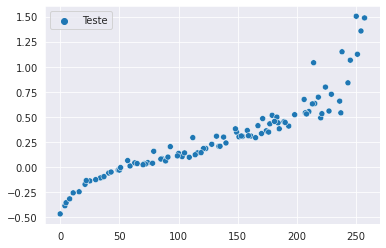

In [309]:
g = sns.scatterplot(data=y_pred)

# 5 split

0.9887531873290792


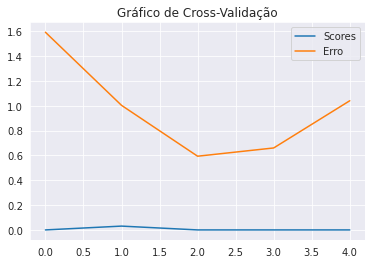

In [310]:
folds = KFold(n_splits = 5)
scores = cross_val_score(clf, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(clf, X_test, y_test, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

# 10 split

0.934375300520584


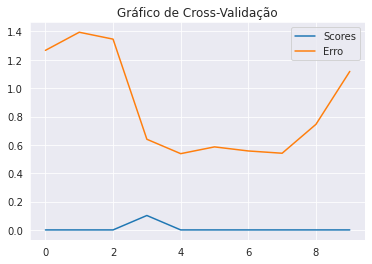

In [311]:
folds = KFold(n_splits = 10)
scores = cross_val_score(clf, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(clf, X_test, y_test, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

# PLS regression

In [312]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
y_pls = pls.predict(X_test)


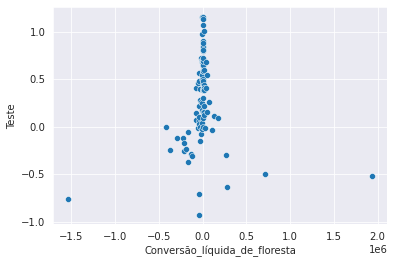

In [313]:
y_prev = pd.DataFrame(y_pls, index=y_test.index, columns=['Teste'])
dp = pd.concat([data_test, y_prev], axis=1)
g = sns.scatterplot(x='Conversão_líquida_de_floresta', y = 'Teste',data=dp)

#  Plot da regressão PLS

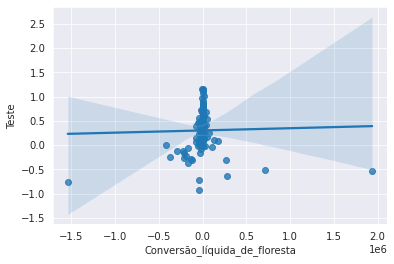

In [314]:
g = sns.regplot(x='Conversão_líquida_de_floresta', y = 'Teste',data=dp)

# 5 split

1.0518752875103436


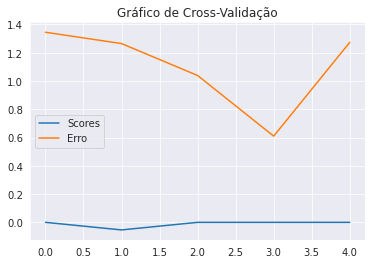

In [315]:
folds = KFold(n_splits = 5)
scores = cross_val_score(pls, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(pls, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

# 10 split

0.9546200455245814


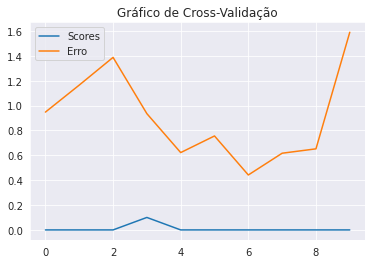

In [316]:
folds = KFold(n_splits = 10)
scores = cross_val_score(pls, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(pls, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

#                                                       Abordando o problema de forma diferente

In [317]:
data = normalizaPelaPop(data)

# Normalização dos dados pela população de cada país, assim o modelo irá prever o desmatamento por pessoa

In [318]:
br = data[(data["Código"] == "BRA") & ((data["Ano"] == 1990) | (data["Ano"] == 2000))]

In [319]:
br

,Entidade,Código,Ano,Conversão_líquida_de_floresta,Área_de_Floresta,Produção_Óleo,População,Perde
3,Brazil,BRA,2000,-0.022603,7.582534e-08,0.025800,174790339,1
2,Brazil,BRA,1990,-0.025375,9.329193e-08,0.020967,149003225,1


In [320]:
def outilers(df, ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)

    IQR = Q3 - Q1

    l_bound = Q1 - 1.5 * IQR

    u_bound = Q3 + 1.5 * IQR

    ls = df.index[(df[ft] < l_bound) | (df[ft] > u_bound)]

    return ls

In [321]:
ls = outilers(data, 'Conversão_líquida_de_floresta')
def removeOutliers(df, ls):
    df = df.drop(ls)
    return df
data = removeOutliers(data, ls)

In [322]:
data_train = data[(data['Ano'] == 1990) | (data['Ano'] == 2000)]
data_test = data[(data['Ano']== 2010)]

In [323]:
data_train = pd.concat([br, data_train], axis = 1)

<AxesSubplot:>

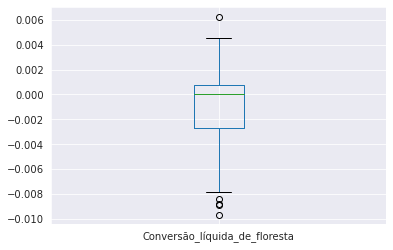

In [324]:
data_test.boxplot(['Conversão_líquida_de_floresta'])

# Os dados são mais comportados sem fazer nenhuma transformação, então é possível remover os outliers

In [325]:
data_string_train, data_value_train,  y_train, target_train = separaData(data)
data_string_test, data_value_test,  y_test, target_test = separaData(data_test)
data_value_train.drop(columns=['População'], inplace=True)
data_value_test.drop(columns=['População'], inplace=True)


In [326]:
def nomeiaColuna(s, s_aux):
    s = pd.DataFrame(s, index=s_aux.index, columns=s_aux.columns)
    return s

In [327]:
def trataDados(data_value, y):
    data_value = tiraDistorcao(data_value)
    y, data_y = yeo_johnson(y)
    y = nomeiaColuna(y, data_y)
    return data_value, y


In [328]:
X_train, y_train = trataDados(data_value_train, y_train)
X_test, y_test = trataDados(data_value_test, y_test)

In [329]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [330]:
y_previsto = modelo.predict(X_test)
metrics.r2_score(y_test, y_previsto).round(3)


0.121

In [331]:
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test).round(3)

0.121

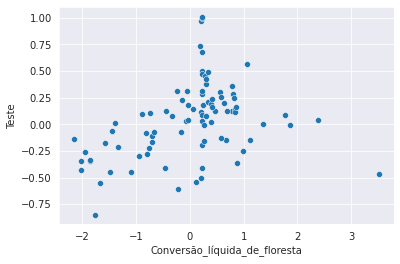

In [332]:
y_previsto = pd.DataFrame(y_previsto, index=y_test.index, columns=['Teste'])
dp = pd.concat([y_test, y_previsto], axis=1)
g = sns.scatterplot(x='Conversão_líquida_de_floresta', y= 'Teste',data=dp)

In [333]:
y_previsto = pd.DataFrame(y_previsto, index=y_test.index, columns=['Teste'])
dp = pd.concat([data_test, y_previsto], axis=1)
dp.Teste = dp.Teste
g = sns.scatterplot


# Plot da regressão linear

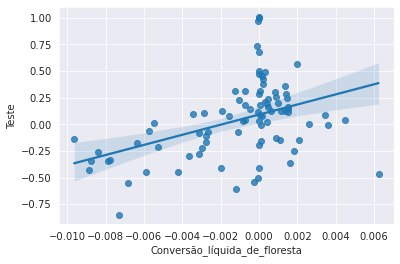

In [334]:
g = sns.regplot(x='Conversão_líquida_de_floresta', y='Teste', data=dp)

In [335]:
error = metrics.mean_squared_error(y_test, y_previsto)
error

0.8793518298715349

1.029007328356528


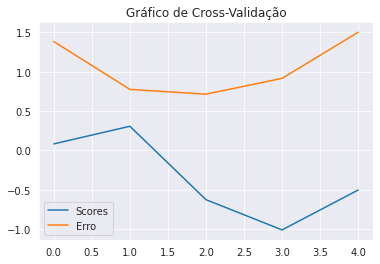

In [336]:
folds = KFold(n_splits = 5)
scores = cross_val_score(modelo, X_train, y_train, scoring='explained_variance', cv=folds)

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

0.9709193155220124


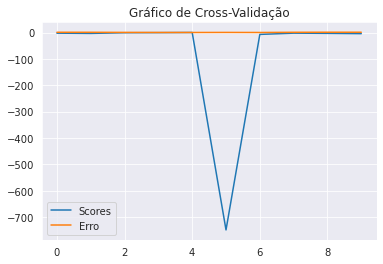

In [337]:
folds = KFold(n_splits = 10)
scores = cross_val_score(modelo, X_train, y_train, scoring='r2', cv=folds)

erro = cross_val_score(modelo, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=scores)
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Scores', 'Erro'])

# Rigde Regression

In [338]:
clf = Ridge()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

scores = clf.score(X_test, y_test)
scores


0.1206197299852464

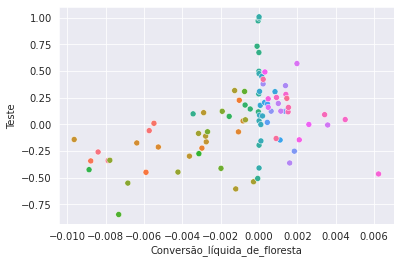

In [339]:
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=['Teste'])
dr = pd.concat([data_test, y_pred], axis=1)
g = sns.scatterplot(x='Conversão_líquida_de_floresta', y='Teste', data=dr, hue=dr.Entidade, legend=False)

# Plot da regressão de Ridge

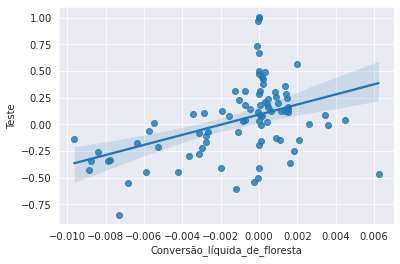

In [340]:
g = sns.regplot(x='Conversão_líquida_de_floresta', y='Teste', data=dr)

# 5 split

1.047263029693866


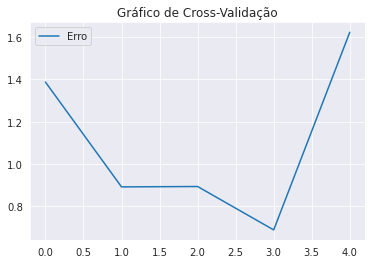

In [341]:
folds = KFold(n_splits = 5)

erro = cross_val_score(clf, X_test, y_test, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Erro'])

# 10 split

0.9925083780388684


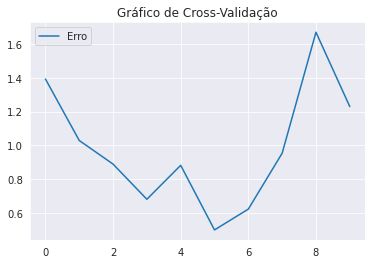

In [342]:
folds = KFold(n_splits = 10)

erro = cross_val_score(clf, X_test, y_test, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Erro'])

# PLS Regression

In [343]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
y_pls = pls.predict(X_test)

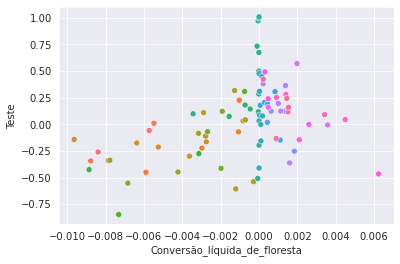

In [344]:
y_prev = pd.DataFrame(y_pls, index=y_test.index, columns=['Teste'])
dp = pd.concat([data_test, y_prev], axis=1)
g = sns.scatterplot(x='Conversão_líquida_de_floresta', y = 'Teste',data=dp, hue=dp.Entidade, legend=False)

# Plot da regressão PLS

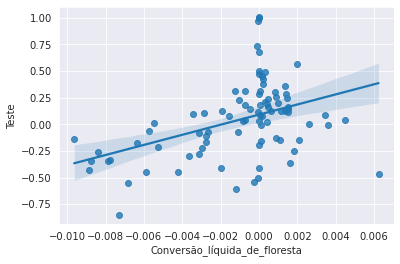

In [345]:
g = sns.regplot(x='Conversão_líquida_de_floresta', y = 'Teste',data=dp)

In [354]:
pls.score(X_test, y_test)

0.12064817012846507

# 5 split

1.029007328356528


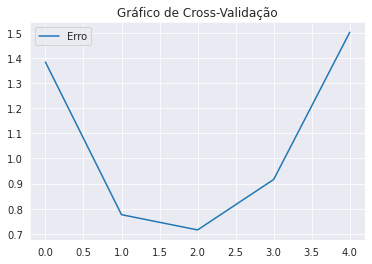

In [346]:
folds = KFold(n_splits = 5)

erro = cross_val_score(pls, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Erro'])

# 10 split

0.9709193155220124


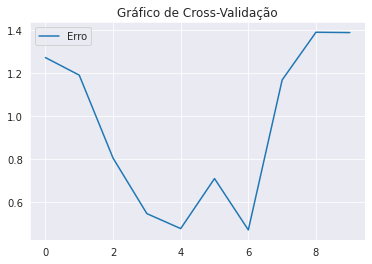

In [347]:
folds = KFold(n_splits = 10)

erro = cross_val_score(pls, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
print(np.sqrt(np.mean(abs(erro))))
sns.lineplot(data=erro*(-1))
plt.title("Gráfico de Cross-Validação")
plt.legend(labels=['Erro'])

In [348]:
dp.to_csv('previsto.csv', index=False)